In [ ]:
# Cargar los datos y obtener el modelo
from common_model import *
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results

prices = []
quantities = []

#real_price_value = 0

m = 0.01


In [ ]:
# Aux: específica de Curva de oferta
# Perform sensitivity analysis of the objective

def perform_sensitivity_analysis():
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()
    
    print("objective:", cpx.solution.sensitivity.objective())
    return cpx.solution.sensitivity.objective()


In [ ]:
# Solves the model for a given price por a product
# price: price to consider
# prod_name: product name ("A", "B", "C")
# prod_number: product number considering their position in the objective (1 = "A", 2 = "B", 3 = "C", ...)
def solve_model_for_price(price, prod_name, prod_number):

    # Función objetivo
    total_benefit = mdl.sum(produccion_vars[p] * (p[1] if p[0] != prod_name else price) for p in products)
    mdl.maximize(total_benefit)

    solution = mdl.solve()
    if solution is not None:
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))

        return solution
    else:
        print("No solution found for price value: {0}".format(price))
        return None  # Return None to indicate that the model is infeasible at this point



In [ ]:
# Report values for the chart

def report(price, quantity):
    prices.append(price)
    quantities.append(quantity) 
    

In [ ]:
# Get quantity of the product in the solution
def get_quantity(prod_number):
    produccion_vars_list = list(produccion_vars.values())
    i = prod_number - 1
    if i >= 0:
        quantity = produccion_vars_list[i].solution_value
        return quantity
    else:
        return None

In [ ]:
### Probando
ord("A") #65
ord("A") - ord("A") + 1 #1
ord("a") - ord("A") + 1 #33
ord("a".upper()) - ord("A") + 1 #1
ord("b".upper()) - ord("A") + 1 #2


2

In [ ]:
# Iterate over prices (from 0 to infinity) starting from current price value
# prod_name: product name ("A", "B", "C"), case insentive
def iterate_over_price(prod_name):
    prod_number = ord(prod_name.upper()) - ord("A") + 1 # position of the product in the objective (1 = "A", 2 = "B", 3 = "C", ...)
    price_position_in_products_vec = 1 # price position in products vector (0=name, 1=benefit, 2=max demand, 3=min demand)
            
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    objective = perform_sensitivity_analysis()

    # Iterate over the lower and upper bounds of the objective of the given product
    for i in range(len(objective)): #Objective has all the coefficients for all products
        
        if i+1 == prod_number: #For the given product
            
            #Print price 0
            price = 0 
            solution = solve_model_for_price(price, prod_name, prod_number)
            quantity = get_quantity(prod_number)
            if quantity is not None:
                report(price, quantity)
            # ********* End of price 0 *********
            
            #Print real price
            prod_idx = prod_number - 1
            if (prod_idx >= 0):
                real_price_value = products[prod_idx][price_position_in_products_vec] 
                solution = solve_model_for_price(real_price_value, prod_name, prod_number)
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(real_price_value, quantity)
            # ********* End of real price *********
                    
            lower = objective[i][0] #Lower price of the current range
            upper = objective[i][1] #Upper price of the current range
    
            # *********Store and report the initial lower and upper bounds for the chart*********
            # Print the lower and upper bounds for price
            print("---Initial lower bound:", lower)            
            price = lower            
            if price >= 0:
                solution = solve_model_for_price(price, prod_name, prod_number)
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price, quantity)
                
            print("---Initial upper bound:", upper)
            price = upper
            # if price <= mdl.infinity:
            #    solution = solve_model_for_price(price, prod_name, prod_number)
            #    if solution is not None:
            #        quantity = get_quantity(prod_number)
            #        if quantity is not None:
            #            report(price, quantity)            
            # ********* End of lower and upper bounds *********
                       
            #Decrease price starting from lower bound - m
            price = lower - m

            while True:
                if price < 0:
                    break ## Stop if the price is lower than 0                
            
                solution = solve_model_for_price(price, prod_name, prod_number)
                if solution is None:
                    break  # Stop if the model is infeasible

                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price+m, quantity) #(xq justo antes de entrar al while se le restó m)
                    
                # Perform sensitivity analysis to get the new lower bound
                new_objective = perform_sensitivity_analysis()
                # Iterate over the lower and upper bounds of the objective of the given product
                for i in range(len(new_objective)): #Objective has all the coefficients for all products

                    if i+1 == prod_number: #For the given product
                        new_lower = new_objective[i][0] #Lower price of the current range
                        #new_upper = new_objective[i][1] #Upper price of the current range
                        
                        price = new_lower
                        print("NEW LOWER:", new_lower)
                        if price < 0:
                            break ## Stop if the price is lower than 0                
                            
                        solution = solve_model_for_price(price, prod_name, prod_number)
                        if solution is None:
                            break  # Stop if the model is infeasible

                        quantity = get_quantity(prod_number)
                        if quantity is not None:
                            report(price, quantity)            
                             
                        price = new_lower - m

                        break


            # Increase price starting from upper bound + m
            price = upper + m
            
            while True:
                if price >= mdl.infinity:
                    break ## Stop if the price reaches or exceeds infinity

                solution = solve_model_for_price(price, prod_name, prod_number)
                
                if solution is None:
                    break  # Stop if the model is infeasible
                
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price-m, quantity) #(xq justo antes de entrar al while se le sumó m)

                # Perform sensitivity analysis to get the new upper bound
                new_objective = perform_sensitivity_analysis()
                # Iterate over the lower and upper bounds of the objective of the given product
                for i in range(len(new_objective)): #Objective has all the coefficients for all products

                    
                    if i+1 == prod_number: #For the given product
                        #new_lower = new_objective[i][0] #Lower price of the current range
                        new_upper = new_objective[i][1] #Upper price of the current range

                        price = new_upper
                        if price >= mdl.infinity:
                            break ## Stop if the price reaches or exceeds infinity

                        solution = solve_model_for_price(price, prod_name, prod_number)
                        if solution is None:
                            break  # Stop if the model is infeasible

                        quantity = get_quantity(prod_number)
                        if quantity is not None:
                            report(price, quantity)  

                        price = new_upper + m #aux: para la sgte vuelta del while
                        break
    return real_price_value
                        

In [ ]:
product_name = "A"
real_price_value = iterate_over_price(product_name)

objective: [(29.999999999999993, 1e+20), (-1e+20, 83.33333333333334), (-1e+20, 50.00000000000001)]
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0
---Initial lower bound: 29.999999999999993
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 50.0
Production of B: 80.0
Production of C: 0
---Initial upper bound: 1e+20
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0
objective: [(-1e+20, 30.0), (-1e+20, 50.0), (29.98999999999999, 1e+20)]
NEW LOWER: -1e+20


In [ ]:
### Aux, probando
round(10.006, 2)
round(10.505, 2) 
#round(10.555, 2)

10.51

In [ ]:
print("prices:", prices)
print("quantities:", quantities) 

# Round all values in the prices list to 2 decimal places    
#prices = [round(price, 2) for price in prices] #

prices: [0, 50, 29.999999999999993, 29.999999999999993]
quantities: [0, 50.0, 50.0, 0]


In [ ]:
### Mejora1
# Armo pares y los ordeno según 'x'
pairs = []
for i in range(len(prices)):
    pairs.append((prices[i], quantities[i]))

print("pairs", pairs)

#pairs.sort()
# Ordeno ascendentemente por la primera componente y Asc por la segunda si hay empates
pairs.sort(key=lambda x: (x[0], x[1]))

print("pairs", pairs)

# Los vuelvo a separar en listas, para no cambiar la función plot
new_x, new_y = [], []
for elem in pairs:
    new_x.append(elem[0])
    new_y.append(elem[1])
print("new_x", new_x)
print("new_y", new_y)

pairs [(0, 0), (50, 50.0), (29.999999999999993, 50.0), (29.999999999999993, 0)]
pairs [(0, 0), (29.999999999999993, 0), (29.999999999999993, 50.0), (50, 50.0)]
new_x [0, 29.999999999999993, 29.999999999999993, 50]
new_y [0, 0, 50.0, 50.0]


In [ ]:
def get_text_for_plot(xunit, yunit):
    xlabel='Precio {0}\n{1}'.format(product_name, xunit)
    ylabel='Cantidad\nProducida {0}\n{1}'.format(product_name, yunit)
    title='Curva de Oferta del Producto {}'.format(product_name)

    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}

plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 0 29.999999999999993
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 29.999999999999993 29.999999999999993
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 29.999999999999993 50
[debug], returned ticks: [<matplotlib.axis.XTick object at 0x7de283cd89a0>, <matplotlib.axis.XTick object at 0x7de283cd8970>, <matplotlib.axis.XTick object at 0x7de283cd8460>, <matplotlib.axis.XTick object at 0x7de283d900a0>]
[debug] real_rhs_value: 50


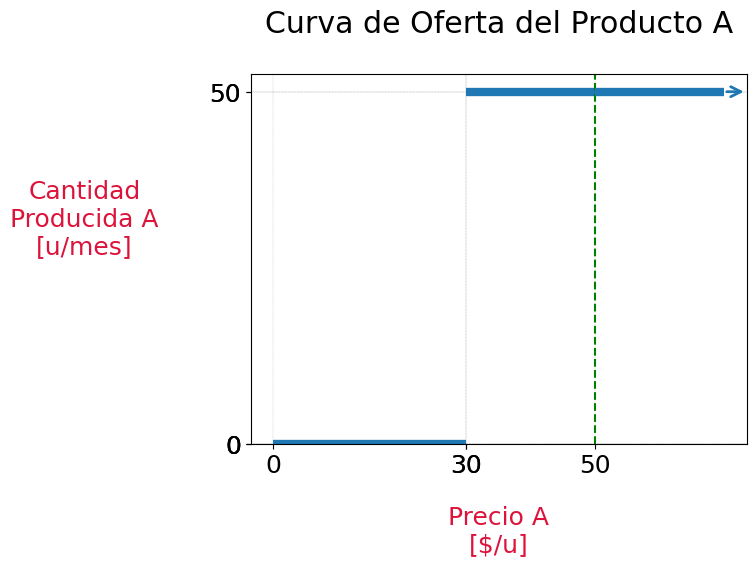

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Graficar
plot_text = get_text_for_plot("[$/u]", "[u/mes]")
plot(new_x, new_y, real_price_value, plot_text)